In [1]:
import numpy as np
import os
import pandas as pd
import time
import umap
import numba
from pathlib import Path
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpImage
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score, precision_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM, DER
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics, \
class_accuracy_metrics, mean_scores_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import my_utils
import my_architectures
import my_dataloaders
import my_transformations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D:\Users\Brian\MscThesis_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calculating the amount of workers usable
number_of_workers = 4

label_mapping = {0: 'No_Glitch', 1: 'Whistle', 2: 'Tomte', 3: 'Scattered_Light'}
# Replace values using the dictionary
#classes = ['No_Glitch', 'Whistle', 'Tomte', 'Scattered_Light']
classes = ['Whistle', 'Tomte', 'Scattered_Light']
print(classes)

['Whistle', 'Tomte', 'Scattered_Light']


In [3]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
#image_dir = 'C:\\Users\\Brian.Baert\\FD_CL\\images\\images'
train_dir = 'D:\\Users\\Brian\\FD_CL\\images\\images'
#test_dir = 'C:\\Users\Brian.Baert\\FD_CL\\images\\test'
test_dir = 'D:\\Users\Brian\\FD_CL\\images\\test'
#FD_location = 'C:\\Users\Brian.Baert\\FD_CL\\reduced_ids_50.npy'
FD_location = 'D:\\Users\Brian\\FD_CL\\reduced_ids_50.npy'

#Load in fratal data
fractal_matrices = np.load(FD_location)
fractal_matrices.shape

#Three classes
classes = ['Whistle', 'Tomte', 'Scattered_Light']

#First image ID = 896

#Label the instances
labels = []
#labels.extend(['No_Glitch'] * 876)
labels.extend(['Whistle'] * 876)
labels.extend(['Tomte'] * 876)
labels.extend(['Scattered_Light'] * 876)
labels = np.array(labels)
print(labels)

['Whistle' 'Whistle' 'Whistle' ... 'Scattered_Light' 'Scattered_Light'
 'Scattered_Light']


In [4]:
fractal_matrices[0]

array([[0.57451844, 0.574585  , 0.61747295, ..., 0.8614793 , 0.8710429 ,
        0.86270547],
       [0.82187957, 0.8134645 , 0.8314725 , ..., 0.87468857, 0.8983555 ,
        0.89641106],
       [0.48615664, 0.5589393 , 0.5859381 , ..., 0.81507933, 0.76803046,
        0.7939468 ],
       ...,
       [0.58207494, 0.478571  , 0.5393343 , ..., 0.7123621 , 0.6273871 ,
        0.64899284],
       [0.45105952, 0.30550978, 0.43062353, ..., 0.39758435, 0.5520664 ,
        0.39632282],
       [0.40403458, 0.32956344, 0.49127063, ..., 0.8159749 , 0.73265237,
        0.83331215]], dtype=float32)

In [5]:
fractal_matrices.shape

(2688, 50, 56)

In [6]:
import torch
from sklearn.preprocessing import LabelEncoder
np_fractal_matrices = torch.from_numpy(fractal_matrices).float()  
# Create a label encoder
le = LabelEncoder()
# Fit the encoder on the training labels
le.fit(labels)
# Convert string labels to numerical labels
Y_train_encoded = le.transform(labels)
# Convert the encoded labels to a long tensor
labels = torch.from_numpy(Y_train_encoded).long()
print(labels.unique())

tensor([0, 1, 2])


D:\Users\Brian\FD_CL\images\images\Whistle
img_1000.png
tensor(1)


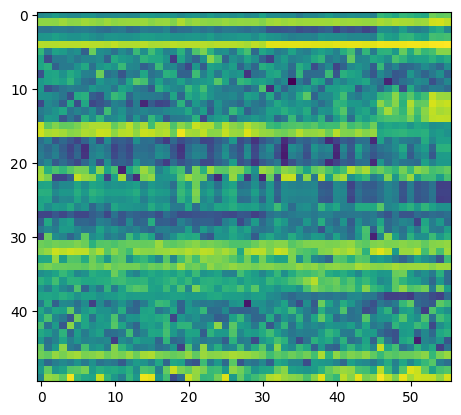

<class 'str'>


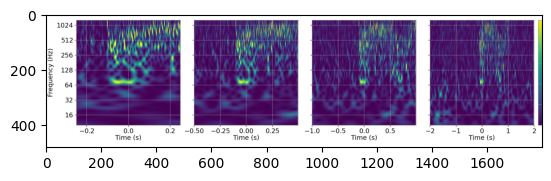

In [7]:
for class_name in classes:
    classpath = os.path.join(train_dir, class_name)
    print(classpath)
    for file in os.listdir(classpath):
        print(f"{file}")
        indx = my_utils.find_index(file)
        print(labels[indx])
        plt.imshow(fractal_matrices[indx])
        plt.show()
        print(type(file))
        plt.imshow(mpImage.imread(os.path.join(classpath,file)))
        plt.show()
        break
    break

In [8]:
train_image_dataset = my_dataloaders.FractalImages(root=train_dir, cls=classes, transform=my_transformations.transformFD_Image)
test_image_dataset = my_dataloaders.FractalImages(root=test_dir, cls=classes, transform=my_transformations.transformFD_Image)
fd_dataset = my_dataloaders.FractalDataset(fractal_matrices, labels)

In [9]:
multimodal_train_dataset = my_dataloaders.MultimodalFractalImages(root=train_dir, cls=classes, fd=fractal_matrices, transform=my_transformations.transformFD_Image)
multimodal_test_dataset = my_dataloaders.MultimodalFractalImages(root=test_dir, cls=classes, fd=fractal_matrices, transform=my_transformations.transformFD_Image)

multimodal_train_dataset_av = AvalancheDataset(multimodal_train_dataset)
multimodal_test_dataset_av = AvalancheDataset(multimodal_test_dataset)

multimodal_train_dataset_av.targets = [label for i, label in enumerate(multimodal_train_dataset.labels)]
multimodal_test_dataset_av.targets = [label for i, label in enumerate(multimodal_test_dataset.labels)]

multimodal_train_dataset_av.uniques = list(set(multimodal_train_dataset.labels))
multimodal_test_dataset_av.uniques = list(set(multimodal_test_dataset.labels))

In [10]:
train_loader = torch.utils.data.DataLoader(multimodal_train_dataset, batch_size=16, shuffle=True, num_workers=number_of_workers)
test_loader = torch.utils.data.DataLoader(multimodal_test_dataset, batch_size=1, shuffle=False)

In [28]:
batch = next(iter(multimodal_train_dataset))
image, label, matrix = batch
print(matrix.shape)
print(label)
print(image.shape)

(50, 56)
0
torch.Size([3, 448, 448])


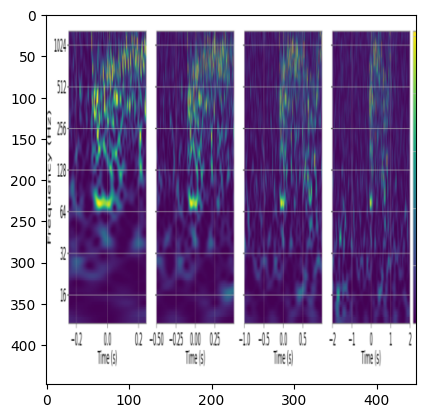

In [30]:
image = image.numpy().transpose((1,2,0))
plt.imshow(image)

In [22]:
from torch.utils.tensorboard import SummaryWriter
num_epochs=30
writer = SummaryWriter('RQ3_logs_small')
# Instantiate the model
model = my_architectures.MultiModalNet(num_classes=3)
model.apply(my_utils.weights_init)
model = model.to(device)  # Move model to GPU if available

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

print("Entering training loop")
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch number {epoch} is starting")
    running_loss = 0.0
    correct = 0
    total = 0
    
    model.train()  # Set the model to training mode
    for i, (images, labels, image_fds) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        image_fds = image_fds.to(device)

        # Forward pass
        outputs = model(images, image_fds)
        loss = criterion(outputs, labels)

        # Backward pass and optimizaton
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # log loss
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + i)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {(running_loss / len(train_loader)):.4f}, '
          f'Accuracy: {100 * correct / total:.2f}%')

print('Finished training')
writer.close()


Entering training loop
Epoch number 0 is starting
Epoch [1/30], Loss: 0.4345, Accuracy: 92.30%
Epoch number 1 is starting
Epoch [2/30], Loss: 0.0568, Accuracy: 98.32%
Epoch number 2 is starting
Epoch [3/30], Loss: 0.0708, Accuracy: 97.58%
Epoch number 3 is starting
Epoch [4/30], Loss: 0.0345, Accuracy: 99.02%
Epoch number 4 is starting
Epoch [5/30], Loss: 0.0618, Accuracy: 98.55%
Epoch number 5 is starting
Epoch [6/30], Loss: 0.0459, Accuracy: 98.51%
Epoch number 6 is starting
Epoch [7/30], Loss: 0.0142, Accuracy: 99.65%
Epoch number 7 is starting
Epoch [8/30], Loss: 0.0368, Accuracy: 99.10%
Epoch number 8 is starting
Epoch [9/30], Loss: 0.0864, Accuracy: 98.16%
Epoch number 9 is starting
Epoch [10/30], Loss: 0.0936, Accuracy: 98.08%
Epoch number 10 is starting
Epoch [11/30], Loss: 0.0321, Accuracy: 99.14%
Epoch number 11 is starting
Epoch [12/30], Loss: 0.0205, Accuracy: 99.41%
Epoch number 12 is starting
Epoch [13/30], Loss: 0.0227, Accuracy: 99.41%
Epoch number 13 is starting
Epoch 

In [23]:
# Set the model to evaluation mode
model.eval()
all_preds = []
all_labels = []
# Disable gradient calculation
with torch.no_grad():
    for i, (images, labels, image_fds) in enumerate(test_loader):
        images, image_fds, labels = images.to(device), image_fds.to(device), labels.to(device)
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images, image_fds)
        # Get the index of the maximum value
        _, preds = torch.max(outputs, 1)
        # Append the predictions and labels to the respective lists
        all_preds.append(preds)
        all_labels.append(labels)
# Return the lists of predictions and labels
y_pred_list = torch.cat(all_preds).cpu().numpy()
y_true_list = torch.cat(all_labels).cpu().numpy()

print(classification_report(y_true_list, y_pred_list, target_names=classes))

                 precision    recall  f1-score   support

        Whistle       1.00      1.00      1.00        40
          Tomte       1.00      1.00      1.00        40
Scattered_Light       1.00      1.00      1.00        40

       accuracy                           1.00       120
      macro avg       1.00      1.00      1.00       120
   weighted avg       1.00      1.00      1.00       120



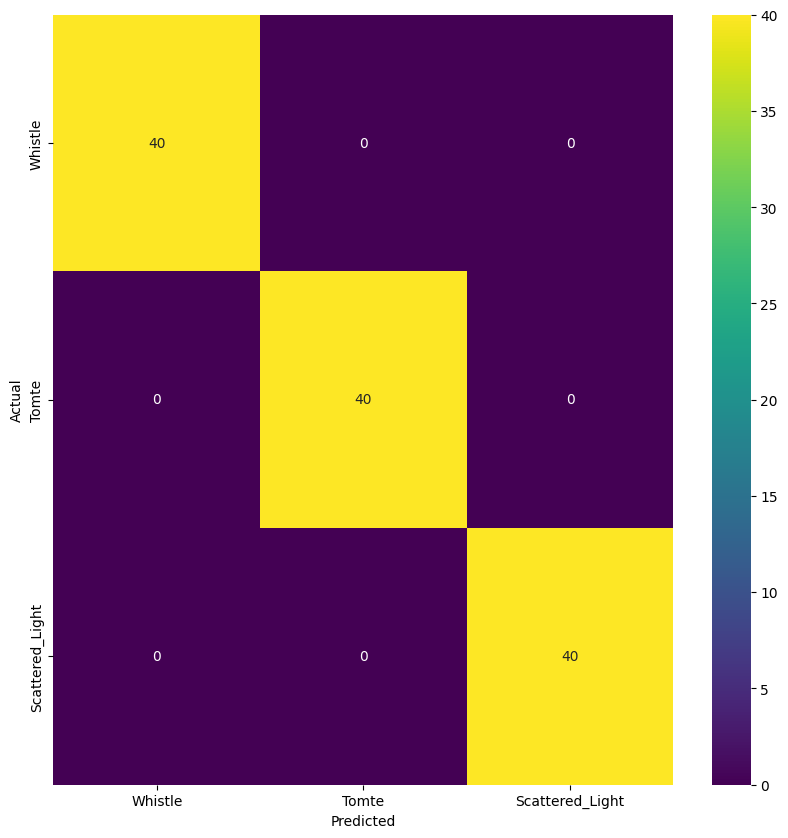

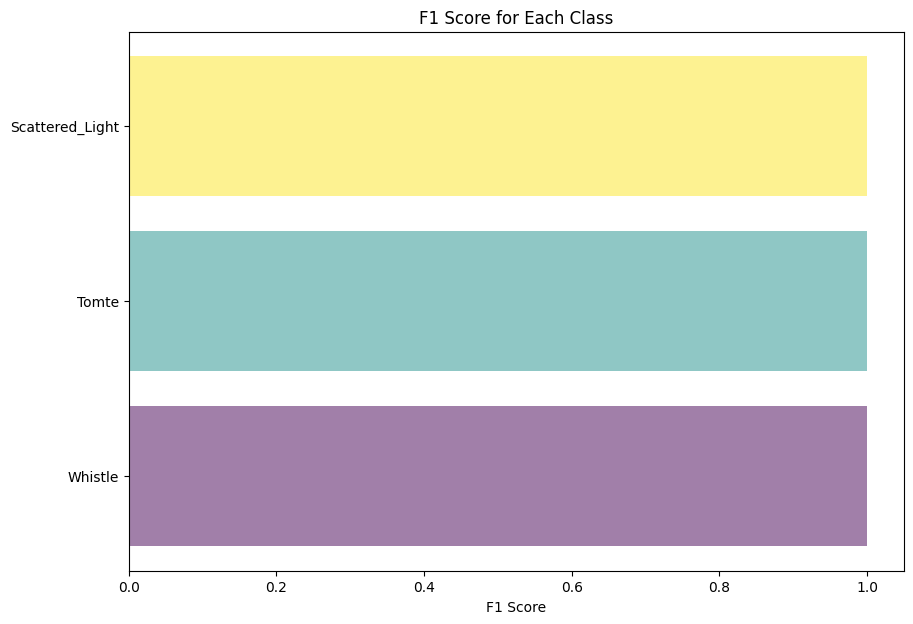

In [24]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/RQ3_ConfusionMatrix.png')
my_utils.plot_f1_scores(f1, classes, 'Results/RQ3_f1_scores.png')

In [25]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_RQ3_Baseline.pth')

Saved Pytorch model state to  Models/thesis_RQ3_Baseline.pth


D:\Users\Brian\MscThesis_env\lib\site-packages\threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


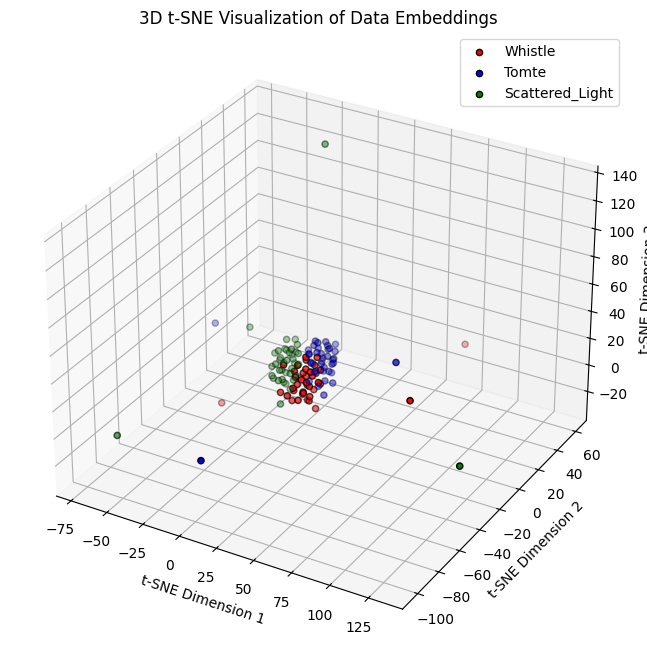

In [26]:
model.eval()

# Initialize lists to store embeddings and labels
embeddings = []
labels = []

# Iterate over the data and collect embeddings
for i, (images, targets, image_fds) in enumerate(test_loader):
    images, image_fds, targets = images.to(device), image_fds.to(device), targets.to(device)
    outputs = model(images, image_fds)
    if torch.cuda.is_available():
        embeddings.append(outputs.cpu().detach().numpy())
        labels.append(targets.cpu().detach().numpy())
    else:
        embeddings.append(outputs.detach().numpy())
        labels.append(targets.detach().numpy())


# Concatenate embeddings and labels
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
embeddings_tsne = tsne.fit_transform(embeddings)

# Create a 3D scatter plot of the t-SNE visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define distinct colors for each class
class_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'gray']

# Scatter plot with different colors for each class
for class_label in np.unique(labels):
    ax.scatter(embeddings_tsne[labels == class_label, 0],
               embeddings_tsne[labels == class_label, 1],
               embeddings_tsne[labels == class_label, 2],
               label=classes[int(class_label)],
               c=class_colors[int(class_label)],  # Assign distinct color
               edgecolor='k')

ax.set_title('3D t-SNE Visualization of Data Embeddings')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.legend()  # Show legend with all class labels

plt.show()
fig.savefig('Results/tSNE_MultiModal_test_3D.png')
plt.close()
